<hr style="border:2px solid #808080"> </hr>
<center><h1 style="color:#03122E;"> Álgebra Lineal Numérica IMT2111</h1></center>
<center><h1 style="color:#173F8A;"> Capítulo 2</h3></center>
<center><h1 style="color:#0176DE;"> Prof. Manuel A. Sánchez</h3></center>
<hr style="border:2px solid #808080"> </hr>

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.la import EigenValues_Preconditioner
import matplotlib.pyplot as plt
import numpy as np

## TEST 1: Model Problem the $L^2$ projection

We will test the algorithm with the solution of $L^2$ projection onto the space of continuous piecewise linear functions in $(0,1)^2$ of a function
$$ f= \sin(\pi(x-y)) $$ 

In [10]:
# Solution
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
fes = H1(mesh, order=1)
u, v = fes.TnT()
a = BilinearForm(u*v*dx).Assemble()
f = sin(2*pi*(x-y))*cos(2*pi*(x+y))
b = LinearForm(f*v*dx).Assemble()
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs())*b.vec
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [3]:
def SetL2Proj(mesh, fun=1,p=1, condense=False):
    # H1-conforming Finite Element Space
    fes = H1(mesh, order=p)
    # Trial and Test Functions
    u, v = fes.TnT()
    # Bilinear form 
    a = BilinearForm(fes, symmetric=True, condense=condense)
    a += (u*v)*dx 
    # Linear form
    b = LinearForm(fun*v*dx)
    # Gridfunction
    gfu = GridFunction(fes)
    return fes, a, b, gfu

In [4]:
def SolveL2ProjDirect(a, b, gfu, fes, condense=False):
    a.Assemble()
    b.Assemble()
    # Direct solver
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=condense))
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    return gfu, fes.ndof

In [5]:
def SolveL2ProjIterativeCG(a, b, gfu, fes, condense=False, compute_condnum=False):
    a.Assemble()
    b.Assemble()
    preI = Projector(mask=fes.FreeDofs(coupling=condense), range=True)
    inv = CGSolver(a.mat, pre=preI, maxsteps=10000)
    
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    if compute_condnum is False:
        return gfu, inv.GetSteps()
    else:
        lams = EigenValues_Preconditioner(mat=a.mat, pre=preI)
        kappa = max(lams)/min(lams)
        return gfu, ((inv.GetSteps(), kappa))

### Test 1: parameters

In [6]:
# parametros
paramt1 = dict()
paramt1['h'] = 0.05
paramt1['f'] = sin(2*pi*(x-y))*cos(2*pi*(x+y))
paramt1['p'] = 1
paramt1['levels'] = 7 # <=8 for p=1
paramt1['h0'] = 0.05
paramt1['condense'] = False

In [7]:
mesh = Mesh(unit_square.GenerateMesh(maxh=paramt1['h']))
fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=paramt1['condense'])
gfu_direct, steps = SolveL2ProjDirect(a, b, gfu, fes, condense=paramt1['condense'])
gfu_cg, steps = SolveL2ProjIterativeCG(a, b, gfu, fes, condense=paramt1['condense'], compute_condnum=True)
print(f"number steps of CG iteration: {steps}")

number steps of CG iteration: (28, 18.397677306712737)


In [8]:
Draw(gfu_direct)
Draw(gfu_cg)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [9]:
from time import time

def SolveL2ProjDirect_levels(h, levels, condense=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=condense)
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            SolveL2ProjDirect(a, b, gfu, fes, condense=condense)
        print (f"ndof = {fes.ndof}, time = {time()-start}")
        steps.append ( (fes.ndof, time()-start) )
    return gfu, steps

_, time_direct = SolveL2ProjDirect_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'])

ndof = 508, time = 0.015578508377075195
ndof = 1949, time = 0.04075264930725098
ndof = 7633, time = 0.031242847442626953
ndof = 30209, time = 0.1412520408630371
ndof = 120193, time = 0.456770658493042
ndof = 479489, time = 2.773268938064575
ndof = 1915393, time = 24.603032112121582


In [10]:
def SolveL2ProjIterativeCG_levels(h, levels, condense=False, compute_condnum=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetL2Proj(mesh, p=paramt1['p'], fun=paramt1['f'], condense=condense)
    tiempo = []
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            
            gfu, invsteps = SolveL2ProjIterativeCG(a, b, gfu, fes, condense=condense, compute_condnum=compute_condnum)
            print (f"ndof = {fes.ndof}, time = {time()-start}, steps = {invsteps}")
            tiempo.append ( (fes.ndof, time()-start ))
        steps.append ( (fes.ndof, invsteps ))
    return gfu, tiempo, steps

_, time_cg, steps = SolveL2ProjIterativeCG_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'], compute_condnum=False)

ndof = 508, time = 0.0, steps = 28
ndof = 1949, time = 0.0, steps = 32
ndof = 7633, time = 0.0, steps = 35
ndof = 30209, time = 0.03124260902404785, steps = 38
ndof = 120193, time = 0.17829203605651855, steps = 38
ndof = 479489, time = 0.9352214336395264, steps = 39
ndof = 1915393, time = 2.951247453689575, steps = 39


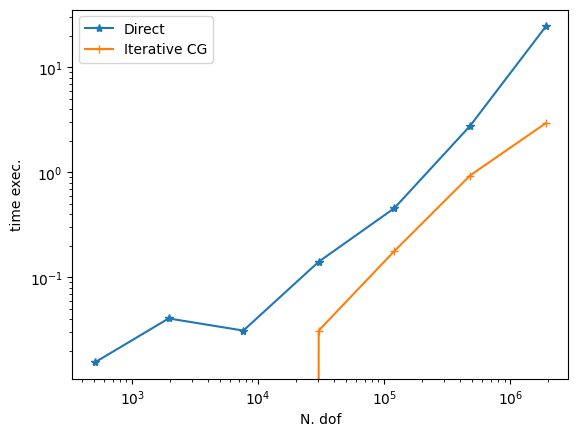

In [11]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*time_direct), "-*")
plt.plot(*zip(*time_cg), "-+")
plt.legend(['Direct', 'Iterative CG'])
plt.xlabel('N. dof')
plt.ylabel('time exec.')
# plt.savefig('03_Module_Test1.png')
plt.show()

# from IPython.display import Image
# Image(filename='03_Module_Test1.png') 

In [31]:
_, _, steps = SolveL2ProjIterativeCG_levels(h=paramt1['h0'], levels=paramt1['levels'], condense=paramt1['condense'], compute_condnum=True)
ndofs = [steps[j][0] for j in range(len(steps))]
nsteps = [steps[j][1][0] for j in range(len(steps))]
kappas = [steps[j][1][1] for j in range(len(steps))]
import pandas as pd
tab = pd.DataFrame({'ndof':ndofs, 'time':np.asarray(time_cg)[:,1], 'Condition number':kappas, 'number of CG iterations': nsteps})
tab     

ndof = 508, time = 0.013055086135864258, steps = (28, 18.748877194835003)
ndof = 1949, time = 0.004985332489013672, steps = (32, 19.323509186693443)
ndof = 7633, time = 0.013057231903076172, steps = (35, 22.16554856051253)
ndof = 30209, time = 0.0402529239654541, steps = (38, 20.939352467609535)
ndof = 120193, time = 0.18178057670593262, steps = (38, 21.844111646744263)
ndof = 479489, time = 0.8869023323059082, steps = (39, 19.92026571866541)
ndof = 1915393, time = 4.408447980880737, steps = (39, 20.181013162883062)


,ndof,time,Condition number,number of CG iterations
0,508,0.036627,18.748877,28
1,1949,0.002993,19.323509,32
2,7633,0.008974,22.165549,35
3,30209,0.034086,20.939352,38
4,120193,0.251893,21.844112,38
5,479489,0.660736,19.920266,39
6,1915393,3.202524,20.181013,39


In [12]:
tab2 = Test_scipyCG_example(examplenumber=2, mm=5)
tab2 = tab2.style.set_caption('Example, increasing condition number')
tab2

,m,Matrix dim,Condition number,number of CG iterations
0,5,25,13.928203,13
1,10,100,48.374150,32
2,20,400,178.064275,63
3,40,1600,680.617070,124
4,80,6400,2658.406502,200


## TEST 2: Model Problem the $L^2$ projection on surface

We will test the algorithm with the solution of $L^2$ projection onto the space of continuous piecewise linear functions in a surface of a function
$$ f= \sin(\pi(x-y)) $$ 

In [2]:
# from netgen.meshing import MeshingStep
# import netgen.stl as stl
# from netgen.webgui import Draw as DrawGeo

# geo = stl.LoadSTLGeometry("spot_triangulated.stl")
# geo = stl.LoadSTLGeometry("blub_triangulated.stl")
# geo = stl.LoadSTLGeometry("spot_from_gmsh.stl")
mesh = Mesh('spot_from_gmsh.stl')
# mesh_blub = Mesh(geo.GenerateMesh(maxh=1,  perfstepsend=MeshingStep.MESHSURFACE))

NgException: Error opening file spot_from_gmsh.stl

In [17]:
from ngsolve import *
from ngsolve.webgui import Draw

V = H1(mesh_blub, order=1)
u = sin(pi*x)*sin(pi*y)*sin(pi*z)
gf = GridFunction(V)
gf.Set(u)

Draw(gf)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

## TEST32: Model problem the Poisson equation
We will test the algorithm in this notebook with the solution of the following Poisson problem

\begin{equation}
-\Delta u = 1, \quad \text{in } (0,1)^{2}, \qquad u=0, \quad \text{sobre } x=0 \text{ e }y=0.
\end{equation}

In [2]:
# Solution
mesh = Mesh(unit_square.GenerateMesh(maxh=0.05))
fes = H1(mesh, order=1, dirichlet='left|bottom')
u, v = fes.TnT()
a = BilinearForm(InnerProduct(grad(u), grad(v))*dx).Assemble()
b = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs())*b.vec
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Set Poisson problem 

In [3]:
def SetPoisson(mesh, f=1, p=1, dirichlet_bndry=None, condense=False):
    # H1-conforming Finite Element Space
    fes = H1(mesh, order=p, dirichlet=dirichlet_bndry)
    # Trial and Test Functions
    u, v = fes.TnT()
    # Bilinear form 
    a = BilinearForm(fes, symmetric=True, condense=condense)
    a += (grad(u)*grad(v))*dx 
    # Linear form
    b = LinearForm(f*v*dx)
    # Gridfunction
    gfu = GridFunction(fes)
    return fes, a, b, gfu

### Direct solver

In [4]:
def SolvePoissonDirect(a, b, gfu, fes, condense=False):
    a.Assemble()
    b.Assemble()
    # Direct solver
    inv = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=condense))
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    return gfu, fes.ndof

### Iterative method : Conjugate Gradient solver (no preconditioner)

In [5]:
def SolvePoissonIterativeCG(a, b, gfu, fes, condense=False, compute_condnum=False):
    a.Assemble()
    b.Assemble()
#     inv = CGSolver(a.mat, pre=NoPrec(a,fes), maxsteps=10000)
    preI = Projector(mask=fes.FreeDofs(coupling=condense), range=True)
    inv = CGSolver(a.mat, pre=preI, maxsteps=10000)
    
    # Solve steps depend on condense
    if condense:
        b.vec.data += a.harmonic_extension_trans * b.vec
        gfu.vec.data = inv * b.vec
        gfu.vec.data += a.harmonic_extension * gfu.vec
        gfu.vec.data += a.inner_solve * b.vec
    else: 
        gfu.vec.data = inv * b.vec
    if compute_condnum is False:
        return gfu, inv.GetSteps()
    else:
        lams = EigenValues_Preconditioner(mat=a.mat, pre=preI)
        kappa = max(lams)/min(lams)
        return gfu, ((inv.GetSteps(), kappa))

In [6]:
# class Preconditioner identity
class NoPrec(BaseMatrix):
    def __init__ (self, a, fes):
        super(NoPrec, self).__init__()
        self.a = a
        self.fes = fes
    def Mult (self, x, y):
        y[:] = 0.0
        FreeDofsindex = np.where(self.fes.FreeDofs())[0]
        y.FV().NumPy()[FreeDofsindex] = x.FV().NumPy()[FreeDofsindex]
    def Height (self):
        return self.a.mat.shape[0]
    def Width (self):
        return self.a.mat.shape[1]

### TEST 3 parameters 

In [17]:
# parameters
paramt2 = dict()
paramt2['h'] = 0.05
paramt2['f'] = 1
paramt2['p'] = 1 # p = 6 try h0=0.25
paramt2['h0'] = 0.05
paramt2['levels'] = 6 # <=6 if p=1
paramt2['condense'] = False # True does not work

In [18]:
# Mesh
mesh = Mesh(unit_square.GenerateMesh(maxh=paramt2['h']))
# Set Poisson
fes, a, b, gfu = SetPoisson(mesh, p=paramt2['p'], f=paramt2['f'], dirichlet_bndry='bottom|left', condense=paramt2['condense'])
# Solve direct method
gfu_direct, steps = SolvePoissonDirect(a, b, gfu, fes, condense=paramt2['condense'])
# Solve iterative method
gfu_cg, steps = SolvePoissonIterativeCG(a, b, gfu, fes, condense=paramt2['condense'], compute_condnum=True)
print(f"number steps of CG iteration: {steps}")

number steps of CG iteration: (86, 547.3116903613196)


In [19]:
Draw(gfu_direct)
Draw(gfu_cg)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Solving for a sequence of meshes

In [20]:
from time import time
def SolvePoissonDirect_levels(h, levels, condense=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetPoisson(mesh, p =paramt2['p'], dirichlet_bndry='bottom|left', condense=condense)
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            gfu,_ = SolvePoissonDirect(a, b, gfu, fes, condense=condense)
        print (f"ndof = {fes.ndof}, time = {time()-start}")
        steps.append ( (fes.ndof, time()-start) )
    return gfu, steps

_, time_direct = SolvePoissonDirect_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=paramt2['condense'])

ndof = 508, time = 0.014960527420043945
ndof = 1949, time = 0.024097204208374023
ndof = 7633, time = 0.028087139129638672
ndof = 30209, time = 0.14237451553344727
ndof = 120193, time = 0.39797544479370117
ndof = 479489, time = 1.8170368671417236


In [21]:
def SolvePoissonIterativeCG_levels(h, levels, condense=False, compute_condnum=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetPoisson(mesh, p=paramt2['p'], dirichlet_bndry='bottom|left', condense=condense)
    tiempo = []
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        with TaskManager():
            start = time()
            gfu, invsteps = SolvePoissonIterativeCG(a, b, gfu, fes, condense=condense, compute_condnum=compute_condnum)
            print (f"ndof = {fes.ndof}, time = {time()-start}, steps = {invsteps}")
            tiempo.append ( (fes.ndof, time()-start ))
        steps.append ( (fes.ndof, invsteps ))
    return gfu, tiempo, steps

_, time_cg, steps = SolvePoissonIterativeCG_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=paramt2['condense'], compute_condnum=False)

ndof = 508, time = 0.002925395965576172, steps = 86
ndof = 1949, time = 0.008060455322265625, steps = 224
ndof = 7633, time = 0.02601313591003418, steps = 442
ndof = 30209, time = 0.15779495239257812, steps = 885
ndof = 120193, time = 1.6199548244476318, steps = 1780
ndof = 479489, time = 21.66693425178528, steps = 3595


### Comparison plot of execution times

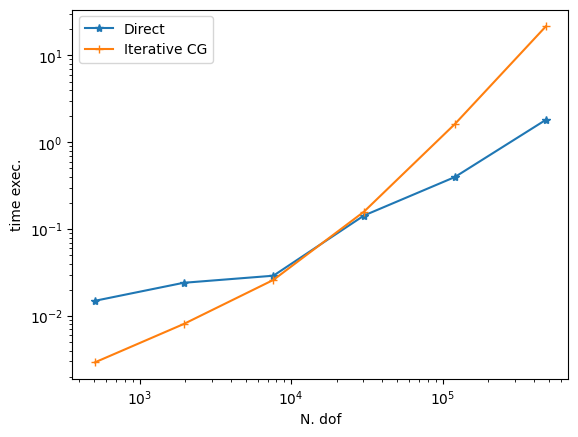

In [22]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*time_direct), "-*")
plt.plot(*zip(*time_cg), "-+")
plt.legend(['Direct', 'Iterative CG'])
plt.xlabel('N. dof')
plt.ylabel('time exec.')
# plt.savefig('03_Module_Test2.png')
plt.show()

# from IPython.display import Image
# Image(filename='03_Module_Test2.png') 

In [23]:
_, _, steps = SolvePoissonIterativeCG_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=False, compute_condnum=True)
ndofs = [steps[j][0] for j in range(len(steps))]
nsteps = [steps[j][1][0] for j in range(len(steps))]
kappas = [steps[j][1][1] for j in range(len(steps))]
import pandas as pd
tab = pd.DataFrame({'ndof':ndofs, 'time':np.asarray(time_cg)[:,1], 'Condition number':kappas, 'number of CG iterations': nsteps})
tab     

ndof = 508, time = 0.0049860477447509766, steps = (86, 547.2917463908642)
ndof = 1949, time = 0.009973526000976562, steps = (224, 3101.5724956743215)
ndof = 7633, time = 0.03091716766357422, steps = (442, 7299.6003124745275)
ndof = 30209, time = 0.17390108108520508, steps = (885, 15872.951056792755)
ndof = 120193, time = 1.5676984786987305, steps = (1780, 31204.531571852516)
ndof = 479489, time = 21.66908574104309, steps = (3595, 62074.9629803932)


,ndof,time,Condition number,number of CG iterations
0,508,0.002925,547.291746,86
1,1949,0.008060,3101.572496,224
2,7633,0.026013,7299.600312,442
3,30209,0.158722,15872.951057,885
4,120193,1.621935,31204.531572,1780
5,479489,21.667932,62074.962980,3595


In [25]:
class Jacobi(BaseMatrix):
    def __init__ (self, smoother):
        super(Jacobi, self).__init__()
        self.smoother = smoother
    def Mult (self, x, y):
        y[:] = 0.0
        self.smoother.Mult(x, y)
    def Height (self):
        return self.smoother.height
    def Width (self):
        return self.smoother.height
class GaussSeidelSym(BaseMatrix):
    def __init__ (self, smoother, steps=1):
        super(GaussSeidelSym, self).__init__()
        self.smoother = smoother
        self.steps = steps
    def Mult (self, x, y):
        y[:] = 0.0
        self.smoother.Smooth(y, x)
        self.smoother.SmoothBack(y, x)
    def Height (self):
        return self.smoother.height
    def Width (self):
        return self.smoother.height

In [33]:
def SolvePoissonIterativePCG_levels(h, levels,condense=False, compute_condnum=False):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes, a, b, gfu = SetPoisson(mesh, p=paramt2['p'], dirichlet_bndry='bottom|left', condense=condense)
    
    tiempo = []
    steps = []
    for l in range(levels):
        if l > 0: mesh.Refine()
        fes.Update()
        gfu.Update()
        a.Assemble()
        b.Assemble()
        preJpoint = a.mat.CreateSmoother(fes.FreeDofs())
#         preJ = Jacobi(preJpoint)
        preJ = GaussSeidelSym(preJpoint)
        with TaskManager():
            start = time()
            solvers.CG(mat=a.mat, pre=preJ, rhs=b.vec, sol=gfu.vec, printrates='\r', tol=1e-6, maxsteps=5000)
#             tiempo.append ( (fes.ndof, time()-start ))
#         steps.append ( (fes.ndof, invsteps ))
    return gfu#, tiempo, steps

_ = SolvePoissonIterativePCG_levels(h=paramt2['h0'], levels=paramt2['levels'], condense=paramt2['condense'], compute_condnum=False)

CG converged in 31 iterations to residual 2.180955884613421e-08
CG converged in 87 iterations to residual 1.59754619915152e-08
CG converged in 175 iterations to residual 7.642953486809177e-09


CG converged in 354 iterations to residual 4.541612084409411e-09
CG converged in 721 iterations to residual 2.244318828892774e-09
CG converged in 1465 iterations to residual 1.1751201935552332e-09
